# Exercise 1

The figure below is the RF front end block diagram of the Motorola M12 Oncore GPS receiver. What are the IF signal frequencies after the first and second mixer down-conversion ($f_{IF_1}$ and $f_{IF_2}$)?  What is the ADC sampling frequency $f_s$? What is the ADC output signal center frequency $f_0$ and bandwidth?

![Motorola M12 Oncore GPS Receiver RF Front End Block Diagram](../lecture-6/diagram.png)

In [2]:
f_L1 = 1.57542e9      # L1 Frequency
f_LO = 16.368e6       # Local Oscillator Frequency
f_M1 = f_LO * 100     # First Mixer Frequency
f_IF1 = f_L1 - f_M1   # First Intermediate Frequency
f_M2 = f_LO * 4       # Second Mixer Frequency
f_IF2 = f_IF1 + f_M2  # Second Intermediate Frequency;  note the addition here*
f_ADC = f_LO / 3      # ADC Sampling Frequency

# The addition in the second mixer stage occurs because the mixer
# can produce both sum and difference frequencies, and in this case,
# the sum frequency is used because it is closer to 0 Hz.

# Since f_L1 maps to f_IF2, the ADC output signal center frequency f_0 is f_L1 - f_IF2
f_0 = f_L1 - f_IF2

print(f"First Intermediate Frequency (f_IF1): {f_IF1 / 1e6:.2f} MHz")
print(f"Second Intermediate Frequency (f_IF2): {f_IF2 / 1e6:.2f} MHz")
print(f"ADC Sampling Frequency (f_s): {f_ADC / 1e6:.2f} MHz")
print(f"ADC Output Signal Center Frequency (f_0): {f_0 / 1e6:.2f} MHz")

First Intermediate Frequency (f_IF1): -61.38 MHz
Second Intermediate Frequency (f_IF2): 4.09 MHz
ADC Sampling Frequency (f_s): 5.46 MHz
ADC Output Signal Center Frequency (f_0): 1571.33 MHz


First Intermediate Frequency ($f_{IF_1}$): -61.38 MHz

Second Intermediate Frequency ($f_{IF_2}$): 4.09 MHz

ADC Sampling Frequency ($f_s$): 5.46 MHz

ADC Output Signal Center Frequency ($f_0$): 1571.33 MHz

# Exercise 2

We showed you the performance of a 1-bit and a 2-bit ADC using a sine function and Gaussian noise as test signal. Write the program that can calculate the output SNR for a 4-bit ADC using a sine function and Gaussian noise. Let the input SNR be -3 dB. You may let input signal frequency be 1.25 MHz and sampling frequency be 5 MHz.

Please make a table like the one on slide 27 to show statistical performance of your ADC output SNR. This will help you to learn how to compute SNR. Collect at least 5 data points. You will need to do the SNR calculation later for your project.

Note that for signal model:

$$
x[n] = A \cdot \sin(2 \pi f_0 n T_s) + w[n]
$$

$$
\sigma_\epsilon^2 = \text{var}(w[n])
$$

$$
\text{SNR}_\text{in} = A^2 / (2 \sigma_\epsilon^2)
$$

and the input bandwidth is $f_s / 2$.



In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def quantize_signal(
        input_samples: np.ndarray,
        num_bits: int,
        max_val: float = None,
    ) -> np.ndarray:
    num_levels = 2 ** num_bits
    if max_val is None:
        max_val = np.max(np.abs(input_samples))
    
    if np.iscomplexobj(input_samples):
        quantized_samples_real = np.floor(input_samples.real / max_val * (num_levels / 2))
        quantized_samples_imag = np.floor(input_samples.imag / max_val * (num_levels / 2))
        quantized_samples = quantized_samples_real + 1j * quantized_samples_imag
        return quantized_samples
    else:
        quantized_samples = np.floor(input_samples / max_val * (num_levels / 2))
        return quantized_samples


def compute_quantized_sinusoid_signal(
        num_bits: int,
        input_snr_db: float,
        num_samples: int = 100000,
        samp_rate: float = 5e6,
        sig_freq: float = 0,
        ignore_quantization: bool = False
    ) -> np.ndarray:
    noise_samples = (
            np.random.randn(num_samples) + 1j * np.random.randn(num_samples)
        ) / np.sqrt(2)
    input_snr = 10 ** (input_snr_db / 10)
    signal_amp = np.sqrt(input_snr)
    time_arr = np.arange(num_samples) / samp_rate
    signal_samples = signal_amp * np.exp(1j * 2 * np.pi * sig_freq * time_arr)
    input_samples = signal_samples + noise_samples
    if ignore_quantization:
        return input_samples
    quantized_samples = quantize_signal(input_samples, num_bits)
    return quantized_samples

In [ ]:
num_bits = 4
input_snr_db = -3
samp_rate = 5e6
duration_sec = 0.01
sig_freq = 1.25e6# + 1. / duration_sec / 2
num_samples = int(samp_rate * duration_sec)

quantized_samples = compute_quantized_sinusoid_signal(
    num_bits,
    input_snr_db,
    num_samples,
    samp_rate,
    sig_freq,
    # ignore_quantization=True
)
# quantized_samples = quantized_samples / np.std(quantized_samples)

fft_freq = np.fft.fftfreq(num_samples, d=1 / samp_rate)
fft_vals = np.fft.fft(quantized_samples)
fft_power = np.abs(fft_vals)**2
_peak_index = np.argmax(fft_power)
signal_power_fft_est = fft_power[_peak_index]
fft_var = np.var(fft_vals[num_samples // 2:])
noise_power_est = fft_var

# Note: when estimating signal power from FFT, there is potentially
# additional correlation loss due to the FFT resolution.
# To avoid this, we can directly correlate with a replica carrier.
# But we will still use the FFT-based noise power estimate.
time_arr = np.arange(num_samples) / samp_rate
replica_carrier = np.exp(1j * 2 * np.pi * sig_freq * time_arr)
signal_power_est = np.abs(np.sum(quantized_samples * np.conj(replica_carrier)))**2

output_est_snr_dB = 10 * np.log10(signal_power_est / noise_power_est)
processing_gain_dB = 10 * np.log10((samp_rate) / (1 / duration_sec))
quantization_loss = input_snr_db + processing_gain_dB - output_est_snr_dB

print(f"Input SNR: {input_snr_db} dB")
print(f"Processing Gain: {processing_gain_dB:.2f} dB")
print(f"Input SNR Plus Processing Gain: {input_snr_db + processing_gain_dB:.2f} dB")
print(f"Estimated Output SNR: {output_est_snr_dB:.2f} dB")
print(f"Quantization Loss: {quantization_loss:.2f} dB")

Input SNR: -6 dB
Processing Gain: 46.99 dB
Input SNR Plus Processing Gain: 40.99 dB
Estimated Output SNR: 41.05 dB
Quantization Loss: -0.06 dB


In [236]:
# fig = plt.figure(figsize=(10, 6))
# ax = fig.add_subplot(111)
# ax.plot(fft_freq / 1e6, fft_power)
# ax.set_title(f'FFT of 4-bit Quantized Signal (Input SNR: {input_snr_db} dB)')
# ax.set_xlabel('Frequency [MHz]')
# ax.set_ylabel('Magnitude')
# ax.grid()
# plt.show()

In [241]:
def compute_quantization_loss(
        input_snr_db: float = -3.0,
        samp_rate: float = 5e6,
        sig_freq: float = 1.25e6,
        duration_sec: float = 0.1,
    ):
    num_samples = int(samp_rate * duration_sec)
    quantized_samples = compute_quantized_sinusoid_signal(
        num_bits,
        input_snr_db,
        num_samples,
        samp_rate,
        sig_freq,
    )
    fft_freq = np.fft.fftfreq(num_samples, d=1 / samp_rate)
    fft_vals = np.fft.fft(quantized_samples)
    fft_power = np.abs(fft_vals)**2
    _peak_index = np.argmax(fft_power)
    signal_power_fft_est = fft_power[_peak_index]
    fft_var = np.var(fft_vals[num_samples // 2:])
    noise_power_est = fft_var
    time_arr = np.arange(num_samples) / samp_rate
    replica_carrier = np.exp(1j * 2 * np.pi * sig_freq * time_arr)
    signal_power_est = np.abs(np.sum(quantized_samples * np.conj(replica_carrier)))**2

    output_est_snr_dB = 10 * np.log10(signal_power_est / noise_power_est)
    processing_gain_dB = 10 * np.log10((samp_rate) / (1 / duration_sec))
    quantization_loss = input_snr_db + processing_gain_dB - output_est_snr_dB

    return output_est_snr_dB, processing_gain_dB, quantization_loss

num_trials = 50
num_bits_list = [1, 2, 3, 4, 5, 6, 7, 8]

results = np.zeros((len(num_bits_list), num_trials))
for i, num_bits in enumerate(num_bits_list):
    for j in range(num_trials):
        output_snr_dB, processing_gain_dB, quantization_loss = compute_quantization_loss(
            input_snr_db=-10.0,
            samp_rate=5e6,
            sig_freq=1.25e6,
            duration_sec=0.01,
        )
        results[i, j] = quantization_loss

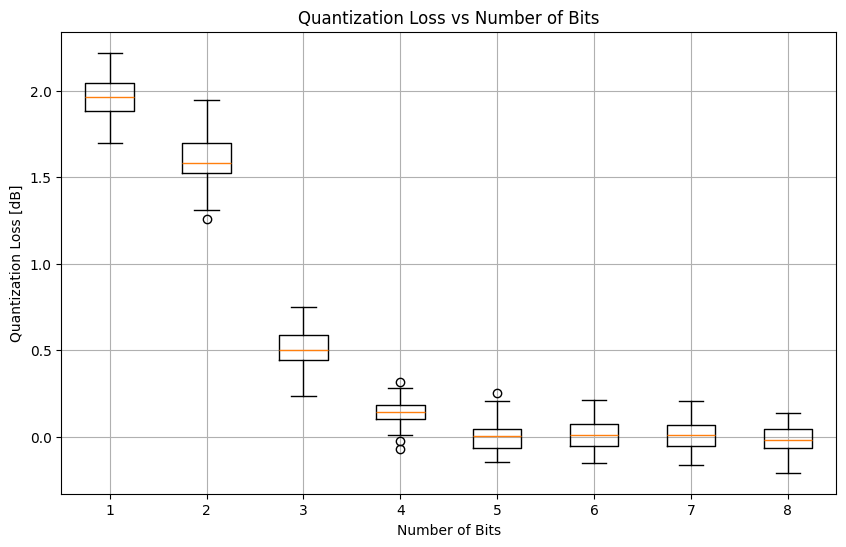

In [242]:
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111)
ax.boxplot(results.T, positions=num_bits_list)
ax.set_title('Quantization Loss vs Number of Bits')
ax.set_xlabel('Number of Bits')
ax.set_ylabel('Quantization Loss [dB]')
ax.grid()
plt.show()